# **Recognize Handwritten Digits**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D 

import os
import shutil
import time

from sklearn.utils import shuffle

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image

from pathlib import Path
from google.colab import files

In [2]:
%%bash

# check if already installed
pip list -v | grep kaggle 
if [ $? -ne 0 ]; then
  pip install kaggle
fi

kaggle                        1.5.12                /usr/local/lib/python3.7/dist-packages pip


In [3]:
dir_path = "/content/kaggle.json"

if not os.path.isfile(dir_path):

  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

else:
  print("Kaggle.json already uploaded!!")

Kaggle.json already uploaded!!


### Download Dataset

In [4]:
%%bash

if [ ! -d /content/datasets ]; then

  mkdir -p /content/datasets

  mkdir -p /root/.kaggle/
  rm /root/.kaggle/kaggle.json
  cp /content/kaggle.json /root/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json

  kaggle datasets download -d clarencezhao/handwritten-math-symbol-dataset

  # mv /content/handwritten-math-symbol-dataset.zip /content/datasets/
  unzip /content/handwritten-math-symbol-dataset.zip -d /content/datasets/
fi


Archive:  /content/handwritten-math-symbol-dataset.zip
  inflating: /content/datasets/eval/decimal val/129.jpg  
  inflating: /content/datasets/eval/decimal val/1590.jpg  
  inflating: /content/datasets/eval/decimal val/2000.jpg  
  inflating: /content/datasets/eval/decimal val/2146.jpg  
  inflating: /content/datasets/eval/decimal val/2303.jpg  
  inflating: /content/datasets/eval/decimal val/2589.jpg  
  inflating: /content/datasets/eval/decimal val/260.jpg  
  inflating: /content/datasets/eval/decimal val/272.jpg  
  inflating: /content/datasets/eval/decimal val/2772.jpg  
  inflating: /content/datasets/eval/decimal val/2929.jpg  
  inflating: /content/datasets/eval/decimal val/299.jpg  
  inflating: /content/datasets/eval/decimal val/3003.jpg  
  inflating: /content/datasets/eval/decimal val/3210.jpg  
  inflating: /content/datasets/eval/decimal val/3235.jpg  
  inflating: /content/datasets/eval/decimal val/331.jpg  
  inflating: /content/datasets/eval/decimal val/363.jpg  
  infl

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory
100%|##########| 57.8M/57.8M [00:00<00:00, 84.7MB/s]


Dataset contains 135x155 JPG format images of numbers and maths operators.
- Contains 7012 images in training set and 538 images in the test set
- Our task is to classify images into 16 useful classes like one, two, plus, div etc.



### Helper Constants & Functions

In [5]:
# Constants
TRAIN_PATH = "/content/datasets/train"
TEST_PATH = "/content/datasets/eval"
SAVE_EXTRACTED_IMAGE_PATH = '/content/images'

IMAGE_SIZE = (100, 100)
SEED = 727
BATCH_SIZE = 32
EPOCH = 10
LEARNING_RATE = 1e-3
TOTAL_CATEGORIES = 16
MIN_THRESHOLD_PROABILITY = 0.02

SLASH = "/"
FILE_EXTENSION = ".jpg"
EXTRACTED_IMAGE_EXTENSION = ".png"

In [6]:
def getSaveModelPath(path, extension):
  epochTime = int(time.time())
  return f"{path}_{epochTime}.{extension}"

# SAVE_MODEL_PATH = getSaveModelPath("/content/cnn_model", "h5")

In [7]:
def traverseFilesInDir(directory_in_str, fileExtension):

  pathlist = Path(directory_in_str).glob(f"**/*{fileExtension}")
  paths = []
  for path in pathlist:
      path_in_str = str(path)
      paths.append(path_in_str)
  return paths

# traverseFilesInDir("/content/images", ".png")

In [8]:
def removeUnesscaryLabels(path):

  all_dirs = [tup[0] for tup in os.walk(path)]

  for dir in all_dirs:
    if dir == TRAIN_PATH or dir == TEST_PATH:
      continue

    label = dir.split(SLASH)[4]
    if label not in label_list:
      # remove the dir
      shutil.rmtree(dir)

# removeUnesscaryLabels(TRAIN_PATH)
# [x[0] for x in os.walk(TRAIN_PATH)]

In [9]:
def plot_history(history, accuracy_metric, loss_metric):
    """ Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history[f"{accuracy_metric}"], label="train accuracy")
    axs[0].plot(history.history[f"val_{accuracy_metric}"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history[f"{loss_metric}"], label="train error")
    axs[1].plot(history.history[f"val_{loss_metric}"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [10]:
# Collect nesscary labels

label_list = ['zero', 'one', 'two', 'three', 'four', 'five', 
              'six', 'seven', 'eight', 'nine', 
              'div', 'equal', 'minus', 'plus cleaned', 'times', 'decimal', # train folders
              'div val', 'equal val', 'minus val', 'plus val', 'times val', 'decimal val' # test folders
             ]

In [11]:
validExtensions = ['png', 'jpeg']
validOperators = ['/', '*', '+', '-']

In [12]:
mapping_test = {
  'zero': 0,
  'one': 1, 
  'two': 2, 
  'three': 3, 
  'four': 4, 
  'five': 5, 
  'six': 6, 
  'seven': 7, 
  'eight': 8, 
  'nine': 9, 
  'div val': 10,
  'equal val': 11, 
  'minus val': 12, 
  'plus val': 13, 
  'times val': 14, 
  'decimal val': 15
}

mapping_train = {
  'zero': 0,
  'one': 1, 
  'two': 2, 
  'three': 3, 
  'four': 4, 
  'five': 5, 
  'six': 6, 
  'seven': 7, 
  'eight': 8, 
  'nine': 9, 
  'div': 10,
  'equal': 11, 
  'minus': 12, 
  'plus cleaned': 13, 
  'times': 14, 
  'decimal': 15
}

reverse_mapping_train = dict(zip(mapping_train.values(), mapping_train.keys()))
reverse_mapping_test = dict(zip(mapping_test.values(), mapping_test.keys()))

In [13]:
def getPredLabel(pred, mapping = reverse_mapping_train, minThreshold = MIN_THRESHOLD_PROABILITY):
  max_proability = np.max(pred)
  if max_proability <= minThreshold:
    return "Unsure about prediction"

  highest_probability_label_key = np.argsort(pred[0])[-1]
  pred_label = mapping[highest_probability_label_key]
  return pred_label

In [14]:
# Standardizing/Normalizing the inputs can make training a lot faster and reduce the chances of getting stuck in local optima hence
# it is highly recommended before inputting the data into the network to train

def imagePreprocessing(imagePath, resizeShape = IMAGE_SIZE, normalise = True):
  image = cv2.imread(imagePath)
  resize_image = cv2.resize(image, resizeShape)
  resize_gray_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2GRAY)
  resize_gray_image = np.array(resize_gray_image)

  if normalise:
    resize_gray_image = resize_gray_image / 255

  return resize_gray_image

### Preprocessing Image Dataset

In [15]:
removeUnesscaryLabels(TRAIN_PATH)
removeUnesscaryLabels(TEST_PATH)

In [16]:
X_train, y_train = [], []
X_test, y_test = [], []

for imagePath in traverseFilesInDir(TRAIN_PATH, ".jpg"):

  label = imagePath.split(SLASH)[4]
  y_train.append(label)
  X_train.append(imagePreprocessing(imagePath))

X_train = np.array(X_train)
y_train = np.array(y_train)

for imagePath in traverseFilesInDir(TEST_PATH, ".jpg"):
  label = imagePath.split(SLASH)[4]
  y_test.append(label)
  X_test.append(imagePreprocessing(imagePath))

X_test = np.array(X_test)
y_test = np.array(y_test)

In [17]:
# Shuffle train and test datasets
X_train, y_train = shuffle(X_train, y_train, random_state=SEED)
X_test, y_test = shuffle(X_test, y_test, random_state=SEED)

In [18]:
# One hot encoding of labels
y_train = np.vectorize(mapping_train.get)(y_train)
y_test = np.vectorize(mapping_test.get)(y_test)

### Verify Input

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7557, 100, 100), (7557,), (1010, 100, 100), (1010,))

Label for the following image --> 11


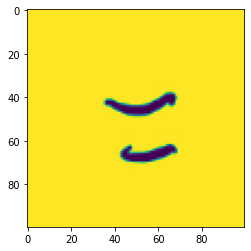

In [20]:
print(f"Label for the following image --> {y_train[7]}")
plt.imshow(X_train[7])

### Let's look at some images!

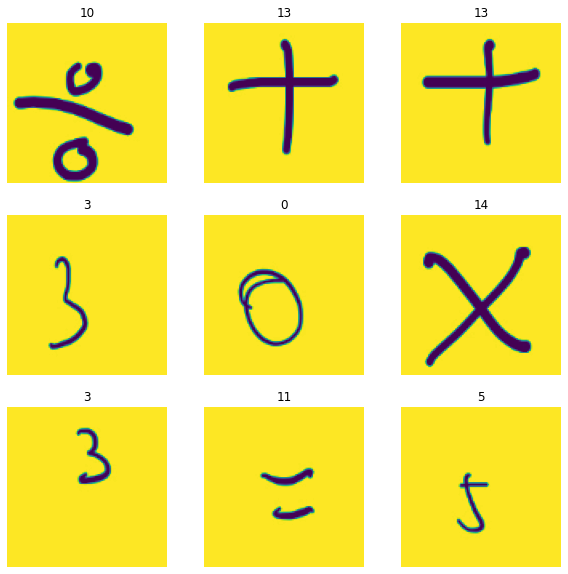

In [21]:
# A sneak peek into the dataset

plt.figure(figsize=(10, 10))

for idx in range(9):
  ax = plt.subplot(3, 3, idx + 1)

  label_name = y_train[idx]

  image = X_train[idx]

  plt.imshow(image)
  plt.title(label_name)
  plt.axis("off")

## Model

### 1) Fully Connected Layer

In [22]:
# from tensorflow.keras.layers import InputLayer
# input_shape = (100, 100, 1)

input_shape = (1, 10000)

In [23]:
model_fcc = Sequential()

model_fcc.add(Flatten())

# model_fcc.add(Dense(10000))
# model_fcc.add(Dropout(0.2))

# model_fcc.add(Dense(5000))
# model_fcc.add(Dropout(0.2))

model_fcc.add(Dense(64))
model_fcc.add(Dropout(0.2))

model_fcc.add(Dense(32))
model_fcc.add(Dropout(0.2))

model_fcc.add(Dense(TOTAL_CATEGORIES, activation='softmax'))

In [24]:
# Difference between sparse categorical cross-entropy and categorical cross-entropy is that sparse categorical cross-entropy 
# is used when output is NOT one-hot encoded(1,2,3 etc.) and categorical cross-entropy when output is one-hot encoded( [1,0,0] or [0,1,0] ). 
# Sparse categorical cross-entropy and categorical cross-entropy can be thought of a multi-class variants of log-loss.

# It can be inferred that the data-set is balanced as we have nearly the same amount of data-points in every class.
# This check is necessary for choosing Accuracy as a metric. Other alternatives could be F1-score.

optimizer = Adam(learning_rate=LEARNING_RATE)
loss="sparse_categorical_crossentropy"
metrics=["sparse_categorical_accuracy"]

model_fcc.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [25]:
model_fcc.build(input_shape)
model_fcc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (1, 10000)                0         
                                                                 
 dense (Dense)               (1, 64)                   640064    
                                                                 
 dropout (Dropout)           (1, 64)                   0         
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                                 
 dropout_1 (Dropout)         (1, 32)                   0         
                                                                 
 dense_2 (Dense)             (1, 16)                   528       
                                                                 
Total params: 642,672
Trainable params: 642,672
Non-trai

In [26]:
history_fcc = model_fcc.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH)

Epoch 1/10
237/237 [==============================] - 6s 7ms/step - loss: 7.1714 - sparse_categorical_accuracy: 0.1454
Epoch 2/10
237/237 [==============================] - 2s 6ms/step - loss: 3.7228 - sparse_categorical_accuracy: 0.2391
Epoch 3/10
237/237 [==============================] - 2s 6ms/step - loss: 2.9617 - sparse_categorical_accuracy: 0.2804
Epoch 4/10
237/237 [==============================] - 1s 6ms/step - loss: 2.5703 - sparse_categorical_accuracy: 0.3042
Epoch 5/10
237/237 [==============================] - 2s 7ms/step - loss: 2.4211 - sparse_categorical_accuracy: 0.3237
Epoch 6/10
237/237 [==============================] - 2s 7ms/step - loss: 2.2830 - sparse_categorical_accuracy: 0.3401
Epoch 7/10
237/237 [==============================] - 2s 6ms/step - loss: 2.2187 - sparse_categorical_accuracy: 0.3520
Epoch 8/10
237/237 [==============================] - 1s 6ms/step - loss: 2.1020 - sparse_categorical_accuracy: 0.3761
Epoch 9/10
237/237 [============================

In [27]:
results = model_fcc.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

32/32 [==============================] - 0s 4ms/step - loss: 2.0630 - sparse_categorical_accuracy: 0.3871
test loss, test acc: [2.0629725456237793, 0.38712871074676514]


In [28]:
# predictions = model_fcc.predict(X_test, y_test)
# predictions
# conf_matrix = tf.math.confusion_matrix(labels = y_test, predictions = predictions)

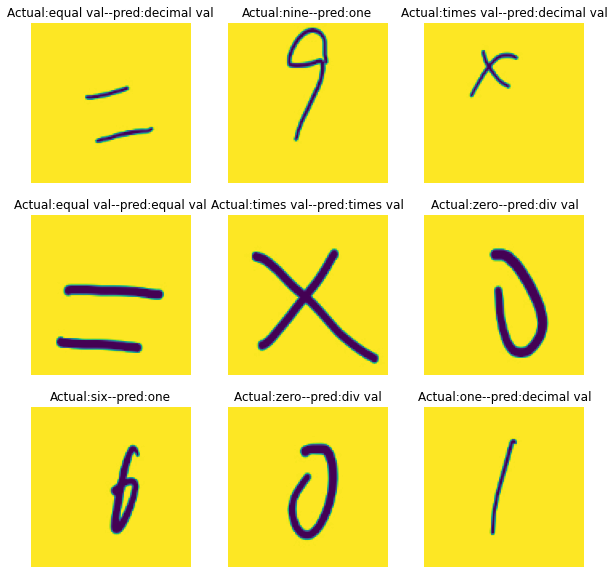

In [29]:
# Viz your models predictions!

plt.figure(figsize=(10, 10))

for idx in range(9):

  ax = plt.subplot(3, 3, idx + 1)

  image = X_test[idx]
  image_copy = image
  resized_image = image.reshape(input_shape)

  actual_label_key = y_test[idx]
  actual_label_name = reverse_mapping_test[actual_label_key]

  pred = model_fcc(resized_image, training=False)
  highest_proability_label_key = np.argsort(pred[0])[-1]
  pred_label = reverse_mapping_test[highest_proability_label_key]

  plt.imshow(image_copy)
  plt.title(f"Actual:{actual_label_name}--pred:{pred_label}")
  plt.axis("off")


Model performance is not upto the mark. Let's try with a convoluted network and see if we can improve the performance. 

### 2) Convolutional Neural Network

In [30]:
input_shape = (100, 100, 1)

In [31]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='valid', name='conv_1', 
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D((2, 2), padding='valid', name='maxpool_1'))

model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='valid', name='conv_2'))
model_cnn.add(MaxPooling2D((2, 2), padding='valid', name='maxpool_2'))

model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_3'))
model_cnn.add(MaxPooling2D((2, 2), padding='valid', name='maxpool_3'))

model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='valid', name='conv_4'))
model_cnn.add(MaxPooling2D((2, 2), padding='valid', name='maxpool_4'))

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(512, activation='relu', name='dense_1'))
model_cnn.add(Dense(256, activation='relu', name='dense_2'))
model_cnn.add(Dense(TOTAL_CATEGORIES, activation = 'softmax', name='output'))


In [32]:
# Difference between sparse categorical cross-entropy and categorical cross-entropy is that sparse categorical cross-entropy 
# is used when output is NOT one-hot encoded(1,2,3 etc.) and categorical cross-entropy when output is one-hot encoded( [1,0,0] or [0,1,0] ). 
# Sparse categorical cross-entropy and categorical cross-entropy can be thought of a multi-class variants of log-loss.

# It can be inferred that the data-set is balanced as we have nearly the same amount of data-points in every class.
# This check is necessary for choosing Accuracy as a metric. Other alternatives could be F1-score.

optimizer = Adam(learning_rate=LEARNING_RATE)
loss = "sparse_categorical_crossentropy"
metrics = ["sparse_categorical_accuracy"]

model_cnn.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [33]:
model_cnn.build(input_shape)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 49, 49, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 47, 47, 64)        18496     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 23, 23, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 21, 21, 128)       73856     
                                                                 
 maxpool_3 (MaxPooling2D)    (None, 10, 10, 128)       0         
                                                                 
 conv_4 (Conv2D)             (None, 8, 8, 128)        

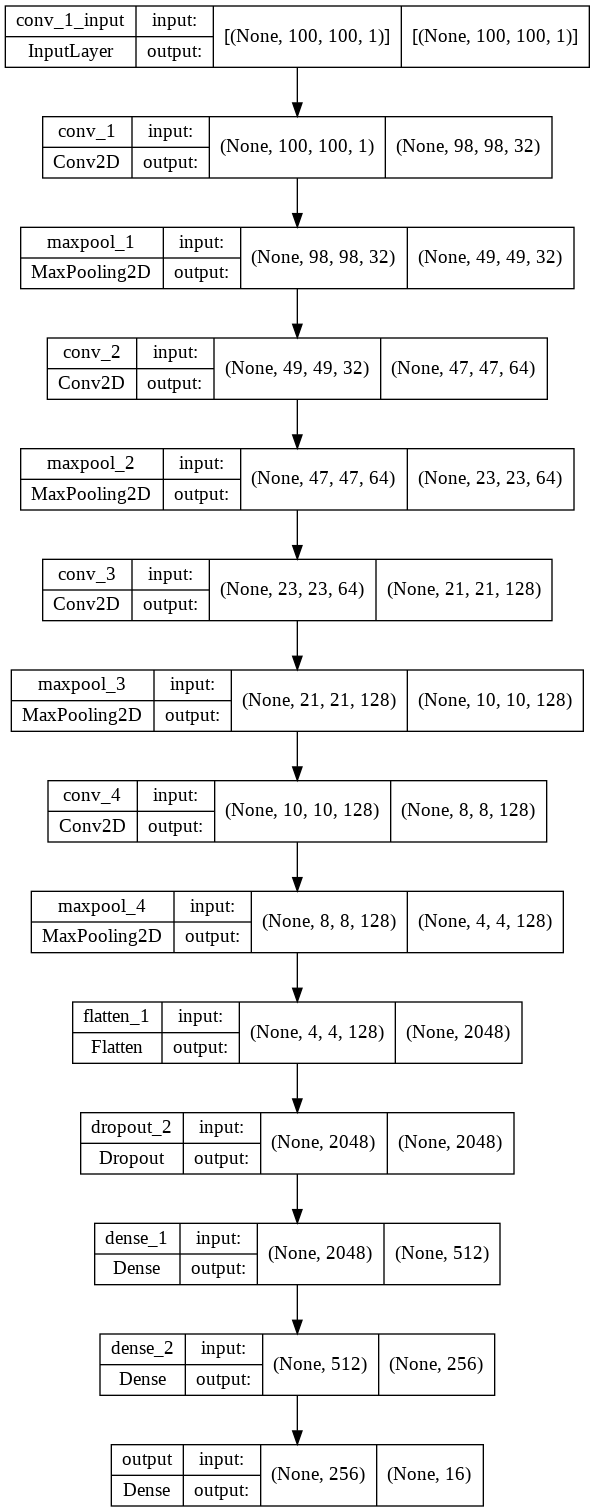

In [34]:
plot_model(model_cnn, show_shapes=True)

In [35]:
history_cnn = model_cnn.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH)

Epoch 1/10
237/237 [==============================] - 16s 35ms/step - loss: 1.2046 - sparse_categorical_accuracy: 0.6151
Epoch 2/10
237/237 [==============================] - 8s 36ms/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8890
Epoch 3/10
237/237 [==============================] - 8s 35ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9377
Epoch 4/10
237/237 [==============================] - 8s 33ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9537
Epoch 5/10
237/237 [==============================] - 8s 32ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9637
Epoch 6/10
237/237 [==============================] - 8s 33ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9681
Epoch 7/10
237/237 [==============================] - 8s 33ms/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9697
Epoch 8/10
237/237 [==============================] - 8s 32ms/step - loss: 0.0613 - sparse_categorical_accuracy: 0.9808
Epoch 9/10
237/237 [===================

In [36]:
results = model_cnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

32/32 [==============================] - 1s 17ms/step - loss: 0.0871 - sparse_categorical_accuracy: 0.9683
test loss, test acc: [0.08705779910087585, 0.9683168530464172]


In [37]:
SAVE_MODEL_PATH = getSaveModelPath("/content/cnn_model", "h5")

model_cnn.save(
    SAVE_MODEL_PATH,
    overwrite=False,
    include_optimizer=True,
    save_format="h5"
)

In [38]:
# from keras.models import load_model
# model_cnn = load_model('/content/cnn_model_.h5')

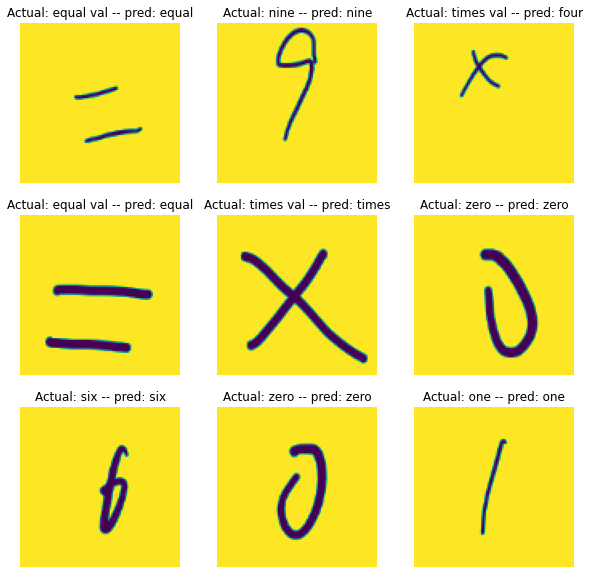

In [39]:
# Viz your models predictions!

plt.figure(figsize=(10, 10))

for idx in range(9):

  ax = plt.subplot(3, 3, idx + 1)

  image = X_test[idx]
  image_copy = image
  resized_image = image.reshape((1, 100, 100))

  actual_label_key = y_test[idx]
  actual_label_name = reverse_mapping_test[actual_label_key]
  
  pred = model_cnn(resized_image, training=False)
  pred_label = getPredLabel(pred, reverse_mapping_train, MIN_THRESHOLD_PROABILITY)

  plt.imshow(image_copy)
  plt.title(f"Actual: {actual_label_name} -- pred: {pred_label}")
  plt.axis("off")

## Intuition on how the model is thinking!

In [40]:
from keras.models import Model

layer_outputs = [layer.output for layer in model_cnn.layers[1:7]]
activation_model = Model(inputs=model_cnn.input, outputs=layer_outputs)

(-0.5, 99.5, 99.5, -0.5)

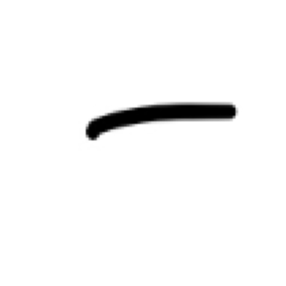

In [41]:
img = X_test[897].reshape(1, 100, 100, 1)
fig = plt.figure(figsize=(5,5))
plt.imshow(img[0,:,:,0], cmap="gray")
plt.axis('off')

In [42]:
activations = activation_model.predict(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


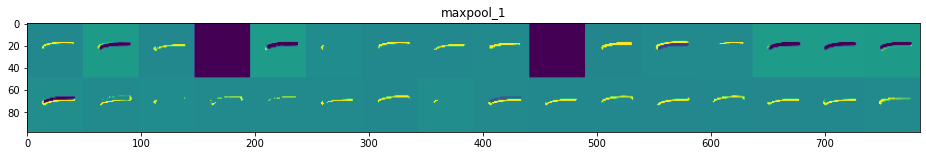

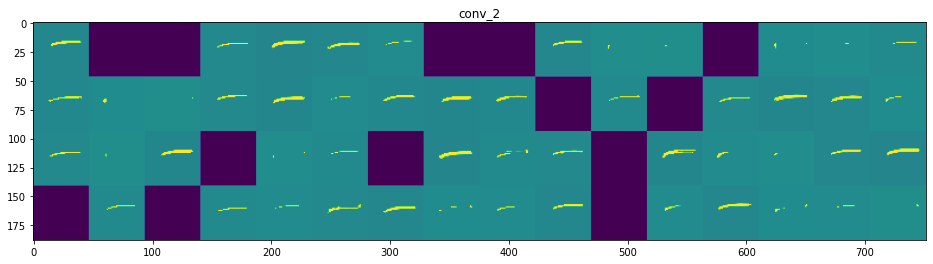

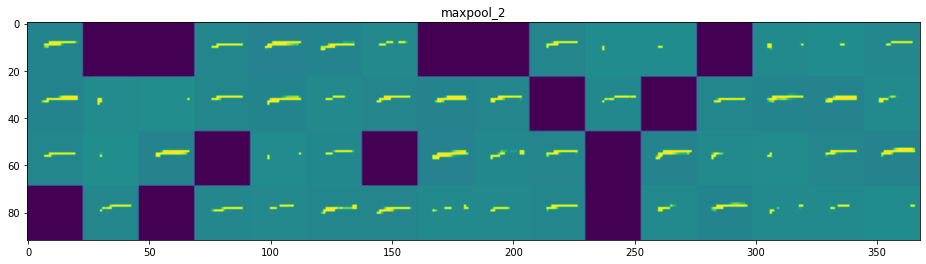

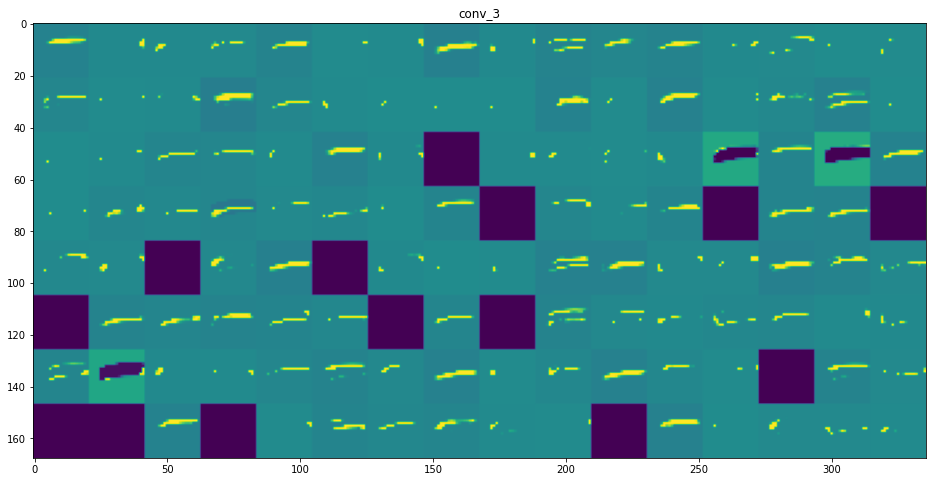

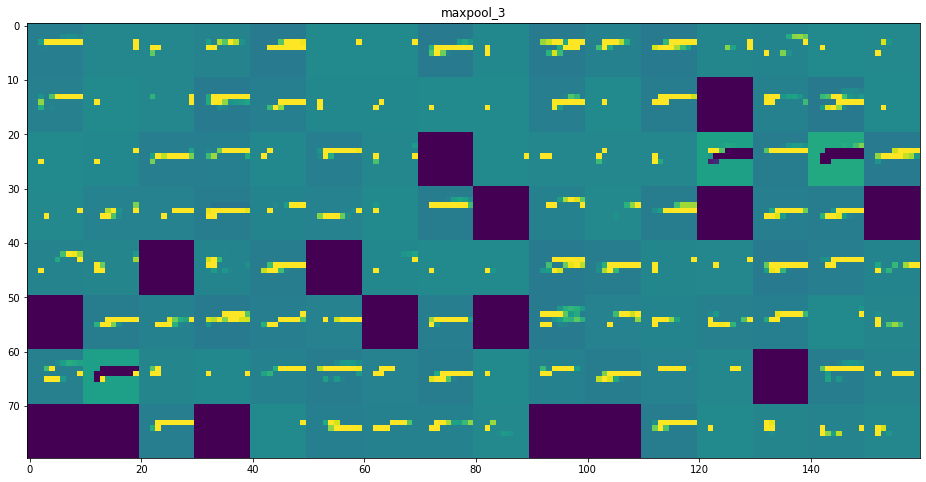

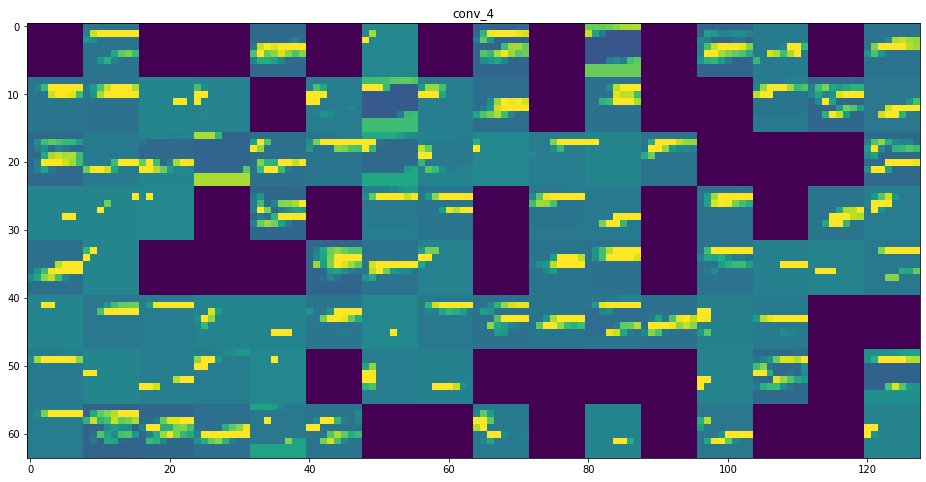

In [43]:
layer_names = []

for layer in model_cnn.layers[1:7]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## References
- https://www.kaggle.com/clarencezhao/handwritten-math-symbol-dataset
- https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca
- https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5
- https://stackoverflow.com/questions/41651628/negative-dimension-size-caused-by-subtracting-3-from-1-for-conv2d